### DPC (Differential Phase Contrast)

**Roberto dos Reis**<br>
Northwestern University
June/2020

The script below is based on multiple sources:

 - [py4DSTEM](https://github.com/py4dstem/py4DSTEM)
 
 - [LiberTEM](https://libertem.github.io/LiberTEM/index.html)
 
 - [Atomap](https://atomap.org/)
 
 - [piXem](https://pixstem.org/index.html)
 
- [Hyperspy](https://hyperspy.org/)

Some of the tools cited have included DPC analysis module. Feel free to test them out!


In [31]:
from scipy import ndimage as scnd
from scipy import optimize as sio
import numpy as np
import warnings
import matplotlib.pyplot as plt


def cart2pol(xx,
             yy):
    rho = np.sqrt(xx**2 + yy**2)
    phi = np.arctan2(yy, xx)
    return(rho, phi)

def pol2cart(rho,
             phi):
    x = np.multiply(rho,np.cos(phi))
    y = np.multiply(rho,np.sin(phi))
    return(x, y)

def angle_fun(angle,
              rho_dpc,
              phi_dpc):
    angle = angle*((np.pi)/180)
    new_phi = phi_dpc + angle
    x_dpc,y_dpc = pol2cart(rho_dpc,new_phi)
    charge = np.gradient(x_dpc)[1] + np.gradient(y_dpc)[0]
    angle_sum = np.sum(np.abs(charge))
    return angle_sum

def optimize_angle(rho_dpc,
                   phi_dpc):
    x0 = 90
    x = sio.minimize(angle_fun,x0,args=(rho_dpc,phi_dpc))
    min_x = x.x
    sol1 = min_x - 90
    sol2 = min_x + 90
    return sol1,sol2

def sobel(input_image):
    """
    Sobel Filter an Input Image
    
    """
    warnings.filterwarnings('ignore')
    Gx = np.asarray(((-1,0,1),
                     (-2,0,2),
                     (-1,0,1)),dtype=input_image.dtype)
    Gy = np.asarray(((-1,-2,-1),
                     (0,0,0),
                     (1,2,1)),dtype=input_image.dtype)
    rows,cols = input_image.shape
    mag = np.zeros((rows,cols),dtype=input_image.dtype)
    ang = np.zeros((rows,cols),dtype=input_image.dtype)
    for ii in range(1,rows - 1):
        for jj in range(1,cols - 1):
            pp = ii - 1
            qq = jj - 1
            image_section = input_image[pp:pp+3,qq:qq+3]
            S1 = (Gx * image_section).sum()
            S2 = (Gy * image_section).sum()
            mag[ii,jj] = ((S1 ** 2)+ (S2 ** 2)) ** 0.5
            ang[ii,jj] = np.arctan2(S2,S1)
    return mag, ang

def make_circle(size_circ,
                center_x,
                center_y,
                radius):
    #Parameters
    #----------
    #size_circ: ndarray 2 element array giving the size of the output matrix
    #center_x: float x position of circle center
    #center_y: float y position of circle center
    #radius: float radius of the circle
    
    #Returns: masked circle ndarray p X q sized array
    
    p = size_circ[0]
    q = size_circ[1]
    yV, xV = np.mgrid[0:p, 0:q]
    sub = ((((yV - center_y) ** 2) + ((xV - center_x) ** 2)) ** 0.5) < radius
    circle = np.asarray(sub,dtype=np.float64)
    return circle

def sobel_circle(image):
    sobel_image,_ = sobel(image)
    yy,xx = np.mgrid[0:sobel_image.shape[0],0:sobel_image.shape[1]]
    center_y, center_x = np.asarray(scnd.measurements.center_of_mass(sobel_image))
    rr = (((yy - center_y) ** 2) + ((xx - center_x) ** 2)) ** 0.5
    initial_guess = gt.initialize_gauss1D(np.ravel(rr),np.ravel(sobel_image),'maxima')
    popt, _ = spo.curve_fit(gt.gaussian_1D_function, xdata=np.ravel(rr), ydata=np.ravel(sobel_image), p0=initial_guess)
    radius = popt[0]
    return center_x,center_y,radius

In [32]:
def image_normalizer(image_orig):
    image_norm = np.zeros_like(image_orig,dtype=np.float64)
    image_norm = (image_orig - np.amin(image_orig)) / (np.amax(image_orig) - np.amin(image_orig))
    return image_norm

In [33]:
import numba

def canny_edge(input_image,
               lowThreshold,
               highThreshold):
    
    blurred_input = scnd.gaussian_filter(input_image,5)
    normalized_blurred = image_normalizer(blurred_input)
    sobel_mag, sobel_angle = sobel(normalized_blurred)
    thinned_edge = edge_thinner(sobel_mag,sobel_angle)
    thresholded_edge = canny_threshold(thinned_edge, lowThreshold, highThreshold)
    joined_edge = edge_joining(thresholded_edge, lowThreshold, highThreshold)
    joined_bool = joined_edge.astype(bool)
    return joined_bool

@numba.jit

def circle_fit(edge_image):
   
    warnings.filterwarnings('ignore')
    size_image = np.asarray(np.shape(edge_image)).astype(int)
    yV, xV = np.mgrid[0:size_image[0], 0:size_image[1]]
    xValues = np.asarray(xV[edge_image],dtype=np.float64)
    yValues = np.asarray(yV[edge_image],dtype=np.float64)
    
    #coordinates of the barycenter
    xCentroid = np.mean(xValues)
    yCentroid = np.mean(yValues)

    # calculation of the reduced coordinates
    uValues = xValues - xCentroid
    vValues = yValues - yCentroid

    # linear system defining the center in reduced coordinates (uc, vc):
    #    Suu * uc +  Suv * vc = (Suuu + Suvv)/2
    #    Suv * uc +  Svv * vc = (Suuv + Svvv)/2

    Suv  = np.sum(uValues * vValues)
    Suu  = np.sum(uValues ** 2)
    Svv  = np.sum(vValues ** 2)
    Suuv = np.sum((uValues ** 2) * vValues)
    Suvv = np.sum(uValues * (vValues ** 2))
    Suuu = np.sum(uValues ** 3)
    Svvv = np.sum(vValues ** 3)

    # Solving the linear system
    A = np.array([ [ Suu, Suv ], [Suv, Svv]])
    B = np.array([ Suuu + Suvv, Svvv + Suuv ])/2.0
    uc, vc = np.linalg.solve(A, B)

    xCenter = xCentroid + uc
    yCenter = yCentroid + vc

    # Calculation of all distances from the center (xc_1, yc_1)
    Rvalues     = np.sqrt(((xValues-xCenter) ** 2) + ((yValues-yCenter) ** 2))
    radius      = np.mean(Rvalues)
    
    return xCenter, yCenter, radius

def edge_thinner(sobel_mag,
                 sobel_angle):
    
    warnings.filterwarnings('ignore')
    thinned_edge = np.zeros(sobel_mag.shape)
    sobel_degree = sobel_angle*(180/np.pi)
    sobel_degree[sobel_degree < 0] += 180
    matrix_size = (np.asarray(sobel_mag.shape)).astype(int)
    for ii in range(1,matrix_size[0]-1):
        for jj in range(1,matrix_size[1]-1):
            q = 1
            r = 1
            if (0 <= sobel_degree[ii,jj] < 22.5) or (157.5 <= sobel_degree[ii,jj] <= 180):
                q = sobel_mag[ii, jj+1]
                r = sobel_mag[ii, jj-1]
            elif (22.5 <= sobel_degree[ii,jj] < 67.5):
                q = sobel_mag[ii+1, jj-1]
                r = sobel_mag[ii-1, jj+1]
            elif (67.5 <= sobel_degree[ii,jj] < 112.5):
                q = sobel_mag[ii+1, jj]
                r = sobel_mag[ii-1, jj]
            elif (112.5 <= sobel_degree[ii,jj] < 157.5):
                q = sobel_mag[ii-1, jj-1]
                r = sobel_mag[ii+1, jj+1]

            if (sobel_mag[ii,jj] >= q) and (sobel_mag[ii,jj] >= r):
                thinned_edge[ii,jj] = sobel_mag[ii,jj]
            else:
                thinned_edge[ii,jj] = 0
    return thinned_edge

def canny_threshold(thinned_edge,
                    lowThreshold,
                    highThreshold):
    """
    Thresholding of Edges
    """
    warnings.filterwarnings('ignore')
    highT = np.amax(thinned_edge) * highThreshold
    lowT = highT * lowThreshold
    residual = np.zeros(thinned_edge.shape)
    residual[np.where(thinned_edge > highT)] = highT
    residual[np.where((thinned_edge <= highT) & (thinned_edge > lowT))] = lowT
    return residual

def edge_joining(thresholded,
                 lowThreshold,
                 highThreshold):
    """
    Joining of Edges
    """
    warnings.filterwarnings('ignore')
    matrix_size = (np.asarray(thresholded.shape)).astype(int)
    thresholded[thresholded > highThreshold] = highThreshold
    for ii in range(1, matrix_size[0]-1):
        for jj in range(1, matrix_size[1]-1):
            if (thresholded[ii,jj] == lowThreshold):
                if ((thresholded[ii-1, jj-1] == highThreshold) #top left
                    or (thresholded[ii-1, jj] == highThreshold) #top
                    or (thresholded[ii-1, jj+1] == highThreshold) #top right
                    or (thresholded[ii, jj-1] == highThreshold) #left
                    or (thresholded[ii, jj+1] == highThreshold) #right
                    or (thresholded[ii+1, jj-1] == highThreshold) #bottom left
                    or (thresholded[ii+1, jj] == highThreshold) #bottom
                    or (thresholded[ii+1, jj+1] == highThreshold)): #bottom right
                    thresholded[ii, jj] = highThreshold
                else:
                    thresholded[ii, jj] = 0
    joined_edge = thresholded /  np.amax(thresholded)
    return joined_edge


### 1. Loading Dataset

In [2]:
# Create sample raw file
import numpy as np
import h5py

sample_data = np.random.randn(16, 16, 16, 16).astype("float32")
# sample_data.tofile("raw_sample.raw")

In [35]:
f = h5py.File('C:/Users/Roberto/Desktop/data_test/calibrationData_circularProbe.h5','r')

In [36]:
f.keys()

<KeysViewHDF5 ['4DSTEM_experiment']>

In [37]:
list(f['4DSTEM_experiment/data/datacubes/polyAu_4DSTEM'].keys())

['data', 'dim1', 'dim2', 'dim3', 'dim4']

In [38]:
#parse each structure into a python data object
class datacube(object):
    data = ''
    metadata = ''
        
    def __init__(self, data, metadata):
        self.data = data
        self.metadata = metadata
        

In [39]:
dc = datacube('','')
dc.data = (f['4DSTEM_experiment/data/datacubes/polyAu_4DSTEM/data'])
dc.metadata = np.array(f['4DSTEM_experiment/metadata'])

In [40]:
dc.data.shape

(100, 84, 250, 250)

In [1]:
BF = np.average(dc.data,axis=(2,3))
aveDP = np.average(dc.data,axis=(0,1))

fig,ax = plt.subplots(1,2,figsize=(8,6))
ax[0].matshow(BF, cmap="inferno")
ax[1].matshow(np.log10(abs(aveDP)), cmap="inferno")

plt.show()

NameError: name 'np' is not defined

In [42]:
# sample_data.shape

In [50]:
def calculate_dpc(data4D):
    data_size = (np.asarray(data4D.shape)).astype(int)
    rho_shift = (np.zeros((data_size[0],data_size[1])))
    phi_shift = (np.zeros((data_size[0],data_size[1])))
#     Mean_r = np.mean(np.mean(data4D,axis=0),axis=1)
    Mean_r = np.average(data4D,axis=(0,1))
    center_x,center_y,data_radius = circle_fit(canny_edge(scnd.median_filter(Mean_r,2),0.2,0.8))
    
    for jj in numba.prange(data_size[1]):
        for ii in range(data_size[0]):
            ronchigram = scnd.median_filter(data4D[ii,jj,:,:],2)
            com_x,com_y = scnd.measurements.center_of_mass(ronchigram)
            shift_x = com_x - center_x
            shift_y = com_y - center_y
            rho,phi = cart2pol(shift_x,shift_y)
            rho_shift[ii,jj] = rho
            phi_shift[ii,jj] = phi
    return(rho_shift, phi_shift)

In [51]:
dpc = calculate_dpc(dc.data)

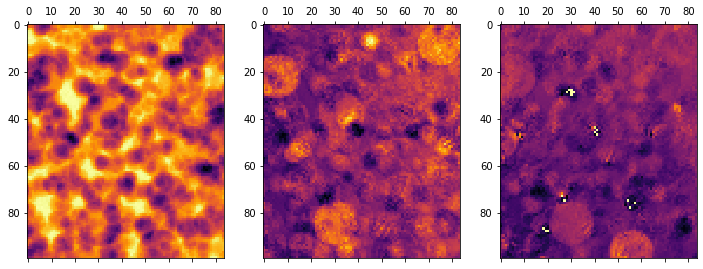

In [57]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,6))
ax1.matshow(BF, cmap="inferno")
ax2.matshow(dpc[0], cmap="inferno")
ax3.matshow(dpc[1], cmap="inferno", vmax = 0.001)

plt.show()